# Double Layer Network Example

**Note**: This notebook is desinged to run on CPU (no GPU) runtime.

**[DLN-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[DLN-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[DLN-03]**

Generate a training dateset.

In [3]:
def generate_datablock(key, n, mu, cov, t):
    data = random.multivariate_normal(
        key, jnp.asarray(mu), jnp.asarray(cov) ,jnp.asarray([n]))
    data = jnp.hstack([data, jnp.ones([n, 1])*t])
    return data

key, key1, key2, key3, key4, key5 = random.split(random.PRNGKey(0), 6)
data1 = generate_datablock(key3, 24, [ 7, -7], [[18, 0], [0, 18]], 0)
data2 = generate_datablock(key4, 24, [-7,  7], [[18, 0], [0, 18]], 0)
data3 = generate_datablock(key1, 24, [ 7,  7], [[18, 0], [0, 18]], 1)
data4 = generate_datablock(key2, 24, [-7, -7], [[18, 0], [0, 18]], 1)

data = jax.random.permutation(key5, jnp.vstack([data1, data2, data3, data4]))
train_x, train_t = jnp.array_split(data, 2, axis=1)

**[DLN-04]**

Define a binary classification model with double hidden layers.

In [4]:
class DoubleLayerModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=2)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=2)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=1)(x)
        if get_logits:
            return x
        x = nn.sigmoid(x)
        return x

**[DLN-05]**

Generate inital parameter values.

In [5]:
key, key1 = random.split(key)
variables = DoubleLayerModel().init(key1, train_x)

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    Dense_0: {
        bias: (2,),
        kernel: (2, 2),
    },
    Dense_1: {
        bias: (2,),
        kernel: (2, 2),
    },
    Dense_2: {
        bias: (1,),
        kernel: (2, 1),
    },
})

**[DLN-05]**

Create a training state object.

In [6]:
state = train_state.TrainState.create(
    apply_fn=DoubleLayerModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[DLN-06]**

Define a loss function as the binary cross entropy. This function also returns the accuracy of the model.

In [7]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.sign(logits) == jnp.sign(labels-0.5))
    return loss, acc

**[DLN-07]**

Define a function to apply a single training step that returns a new training state.

In [8]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[DLN-08]**

Repeat applying the training step.

In [9]:
%%time
loss_history, acc_history = [], []
for step in range(1, 5001):
    state, loss, acc = train_step(state, train_x, train_t)
    loss_history.append(jax.device_get(loss).tolist())
    acc_history.append(jax.device_get(acc).tolist())
    if step % 1000 == 0:
        print ('Step: {}, Loss: {:0.4f}, Accuracy {:0.4f}'.format(step, loss, acc))

Step: 1000, Loss: 0.3427, Accuracy 0.9167
Step: 2000, Loss: 0.2718, Accuracy 0.9271
Step: 3000, Loss: 0.2537, Accuracy 0.9271
Step: 4000, Loss: 0.2469, Accuracy 0.9271
Step: 5000, Loss: 0.2437, Accuracy 0.9271
CPU times: user 1.25 s, sys: 22.9 ms, total: 1.27 s
Wall time: 1.3 s


**[DLN-09]**

Show charts of loss history / accuracy history.

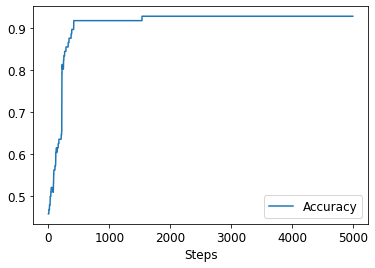

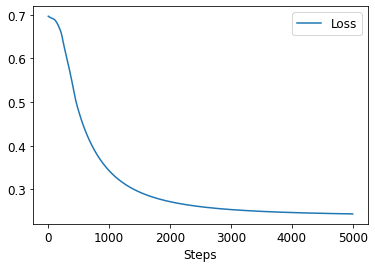

In [10]:
df = DataFrame({'Accuracy': acc_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

df = DataFrame({'Loss': loss_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

**[DLN-10]**

Plot a chart for predictions.

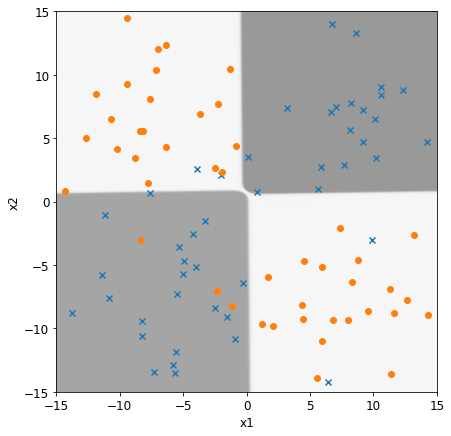

In [11]:
train_set0 = [jax.device_get(x).tolist()
              for x, t in zip(train_x, train_t) if t == 0]
train_set1 = [jax.device_get(x).tolist()
              for x, t in zip(train_x, train_t) if t == 1]

fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([-15, 15])
subplot.set_xlim([-15, 15])
subplot.set_xlabel('x1')
subplot.set_ylabel('x2')
subplot.scatter([x for x, y in train_set1],
                [y for x, y in train_set1], marker='x')
subplot.scatter([x for x, y in train_set0],
                [y for x, y in train_set0], marker='o')

locations = [[x1, x2] for x2 in np.linspace(-15, 15, 500) 
                      for x1 in np.linspace(-15, 15, 500)]
p_vals = state.apply_fn({'params': state.params},
                        np.array(locations)).reshape([500, 500])
_ = subplot.imshow(p_vals, origin='lower', extent=(-15, 15, -15, 15),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r, alpha=0.4)